# Customer Value Analysis (IBM Watson)
## Table of Contents
* Context
* Inspiration
* Source
* Findings

### Context
Using Watson Analytics, to predict behavior to retain your customers. Analysis of relevant customer data with the aim of developing focused customer retention programs.

### Objective
* To demonstrate elbow method for selecting optimal number of clusters
* To demonstrate pca method of dimensionality reduction
* To cluster customer behavior to better understand their engagement levels with the company product


### Inspiration
Understand customer demographics and buying behavior. Use predictive analytics to analyze the most profitable customers and how they interact. Take targeted actions to increase profitable customer response, retention, and growth.

### Source
https://www.ibm.com/communities/analytics/watson-analytics-blog/marketing-customer-value-analysis/

In [71]:
#### Loading Packages 
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

import warnings
warnings.filterwarnings('ignore')

In [72]:
import os
print(os.listdir("../Data"))

['ibm-watson-marketing-customer-value-data.zip', 'WA_Fn-UseC_-Marketing-Campaign-Eff-UseC_-FastF.xlsx', 'WA_Fn-UseC_-Marketing-Customer-Value-Analysis.csv']


In [73]:
#### Data Loading
df = pd.read_csv("../Data/WA_Fn-UseC_-Marketing-Customer-Value-Analysis.csv")

In [74]:
#df.Response = df.Response.apply(lambda X:0 if X == 'No' else 1)

In [75]:
df.head()

,Customer,State,Customer Lifetime Value,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,Income,...,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size
0,BU79786,Washington,2763.519279,No,Basic,Bachelor,2/24/11,Employed,F,56274,...,5,0,1,Corporate Auto,Corporate L3,Offer1,Agent,384.811147,Two-Door Car,Medsize
1,QZ44356,Arizona,6979.535903,No,Extended,Bachelor,1/31/11,Unemployed,F,0,...,42,0,8,Personal Auto,Personal L3,Offer3,Agent,1131.464935,Four-Door Car,Medsize
2,AI49188,Nevada,12887.431650,No,Premium,Bachelor,2/19/11,Employed,F,48767,...,38,0,2,Personal Auto,Personal L3,Offer1,Agent,566.472247,Two-Door Car,Medsize
3,WW63253,California,7645.861827,No,Basic,Bachelor,1/20/11,Unemployed,M,0,...,65,0,7,Corporate Auto,Corporate L2,Offer1,Call Center,529.881344,SUV,Medsize
4,HB64268,Washington,2813.692575,No,Basic,Bachelor,2/3/11,Employed,M,43836,...,44,0,1,Personal Auto,Personal L1,Offer1,Agent,138.130879,Four-Door Car,Medsize


In [76]:
continous_var_df = df.select_dtypes(include=['int64','float'])
continous_var_df.nunique()

Customer Lifetime Value          8041
Income                           5694
Monthly Premium Auto              202
Months Since Last Claim            36
Months Since Policy Inception     100
Number of Open Complaints           6
Number of Policies                  9
Total Claim Amount               5106
dtype: int64

In [77]:
categorical_df = df.select_dtypes(include = 'object')
cat_df = categorical_df.drop(['Customer','Effective To Date'], axis = 1)
cat_df.nunique()

State               5
Response            2
Coverage            3
Education           5
EmploymentStatus    5
Gender              2
Location Code       3
Marital Status      3
Policy Type         3
Policy              9
Renew Offer Type    4
Sales Channel       4
Vehicle Class       6
Vehicle Size        3
dtype: int64

### Exploration and Findings

In [78]:
df.shape

(9134, 24)

In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9134 entries, 0 to 9133
Data columns (total 24 columns):
Customer                         9134 non-null object
State                            9134 non-null object
Customer Lifetime Value          9134 non-null float64
Response                         9134 non-null object
Coverage                         9134 non-null object
Education                        9134 non-null object
Effective To Date                9134 non-null object
EmploymentStatus                 9134 non-null object
Gender                           9134 non-null object
Income                           9134 non-null int64
Location Code                    9134 non-null object
Marital Status                   9134 non-null object
Monthly Premium Auto             9134 non-null int64
Months Since Last Claim          9134 non-null int64
Months Since Policy Inception    9134 non-null int64
Number of Open Complaints        9134 non-null int64
Number of Policies               

In [80]:
df.isnull().sum()

Customer                         0
State                            0
Customer Lifetime Value          0
Response                         0
Coverage                         0
Education                        0
Effective To Date                0
EmploymentStatus                 0
Gender                           0
Income                           0
Location Code                    0
Marital Status                   0
Monthly Premium Auto             0
Months Since Last Claim          0
Months Since Policy Inception    0
Number of Open Complaints        0
Number of Policies               0
Policy Type                      0
Policy                           0
Renew Offer Type                 0
Sales Channel                    0
Total Claim Amount               0
Vehicle Class                    0
Vehicle Size                     0
dtype: int64

In [81]:
df.columns

Index(['Customer', 'State', 'Customer Lifetime Value', 'Response', 'Coverage',
       'Education', 'Effective To Date', 'EmploymentStatus', 'Gender',
       'Income', 'Location Code', 'Marital Status', 'Monthly Premium Auto',
       'Months Since Last Claim', 'Months Since Policy Inception',
       'Number of Open Complaints', 'Number of Policies', 'Policy Type',
       'Policy', 'Renew Offer Type', 'Sales Channel', 'Total Claim Amount',
       'Vehicle Class', 'Vehicle Size'],
      dtype='object')

In [82]:
categorical_df.columns

Index(['Customer', 'State', 'Response', 'Coverage', 'Education',
       'Effective To Date', 'EmploymentStatus', 'Gender', 'Location Code',
       'Marital Status', 'Policy Type', 'Policy', 'Renew Offer Type',
       'Sales Channel', 'Vehicle Class', 'Vehicle Size'],
      dtype='object')

In [83]:
cols = ['Customer', 'State', 'Response', 'Coverage', 'Education',
       'Effective To Date', 'EmploymentStatus', 'Gender', 'Location Code',
       'Marital Status', 'Policy Type', 'Policy', 'Renew Offer Type',
       'Sales Channel', 'Vehicle Class', 'Vehicle Size']

In [84]:
#conversion of categorical data
from sklearn.preprocessing import LabelEncoder
lb = LabelEncoder()

for col in categorical_df[cols]:
    categorical_df[col] = lb.fit_transform(categorical_df[col])

In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9134 entries, 0 to 9133
Data columns (total 24 columns):
Customer                         9134 non-null object
State                            9134 non-null object
Customer Lifetime Value          9134 non-null float64
Response                         9134 non-null object
Coverage                         9134 non-null object
Education                        9134 non-null object
Effective To Date                9134 non-null object
EmploymentStatus                 9134 non-null object
Gender                           9134 non-null object
Income                           9134 non-null int64
Location Code                    9134 non-null object
Marital Status                   9134 non-null object
Monthly Premium Auto             9134 non-null int64
Months Since Last Claim          9134 non-null int64
Months Since Policy Inception    9134 non-null int64
Number of Open Complaints        9134 non-null int64
Number of Policies               

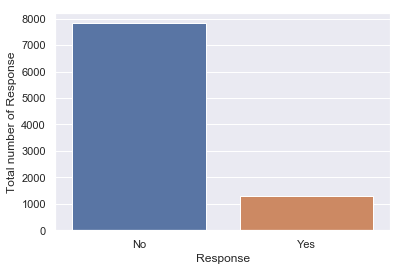

In [86]:
ax = sns.countplot('Response',data = df)
plt.ylabel('Total number of Response')
plt.show()

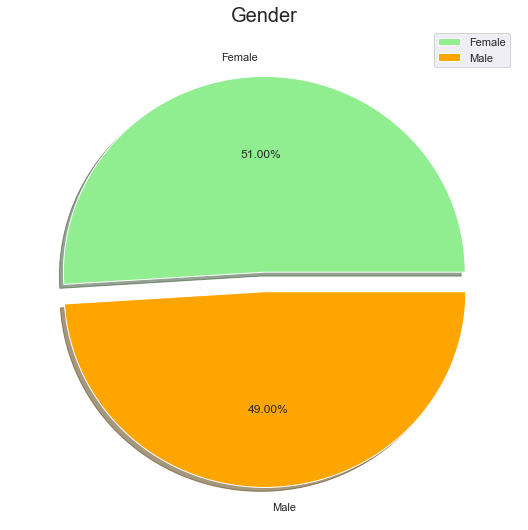

In [87]:
labels = ['Female','Male']
size = df['Gender'].value_counts()
colors = ['lightgreen', 'orange']
explode = [0,0.1]

plt.rcParams['figure.figsize'] = (9,9)
plt.pie(size,colors = colors,explode = explode,labels = labels, shadow = True, autopct = '%.2f%%')
plt.title('Gender', fontsize = 20)
plt.axis('off')
plt.legend()
plt.show()


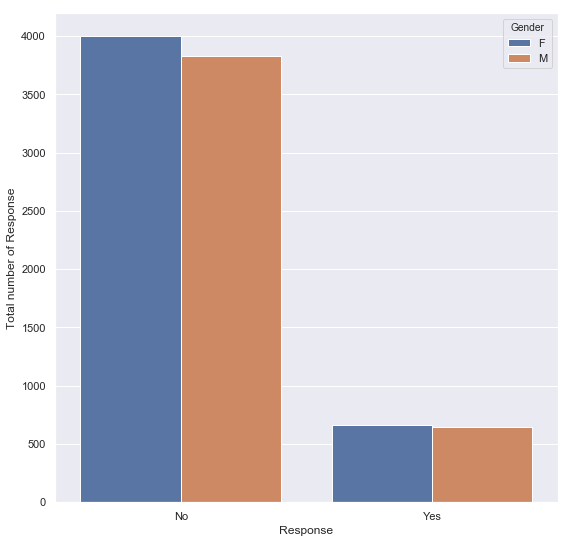

In [88]:
ax = sns.countplot('Response',hue = 'Gender', data = df)
plt.ylabel('Total number of Response')
plt.show()

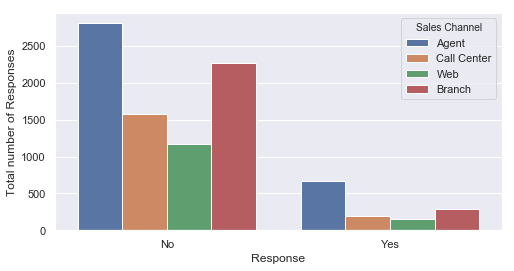

In [89]:
plt.figure(figsize = (8,4))
ax = sns.countplot('Response', hue = 'Sales Channel', data = df)
plt.ylabel('Total number of Responses')
plt.show()

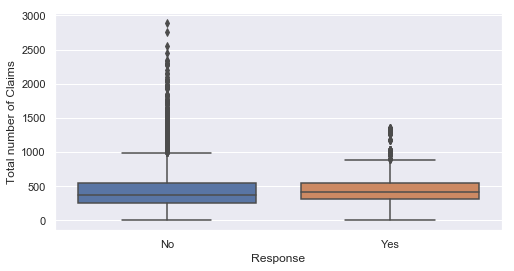

In [90]:
plt.figure(figsize = (8,4))
sns.boxplot(y = 'Total Claim Amount',x = 'Response',data = df)
plt.ylabel('Total number of Claims')
plt.show()

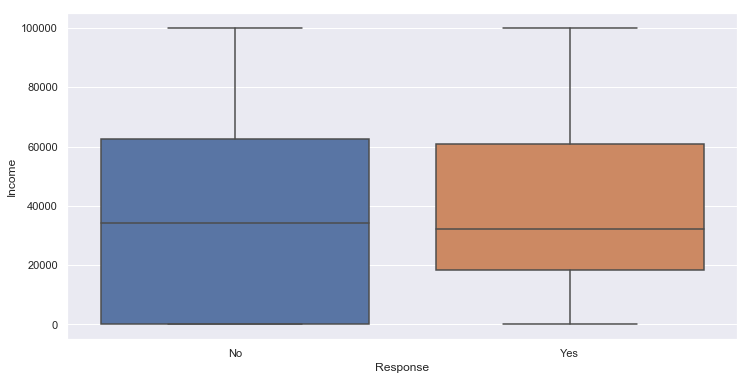

In [91]:
plt.figure(figsize = (12,6))
sns.boxplot(y = 'Income', x = 'Response',data = df)
plt.show()

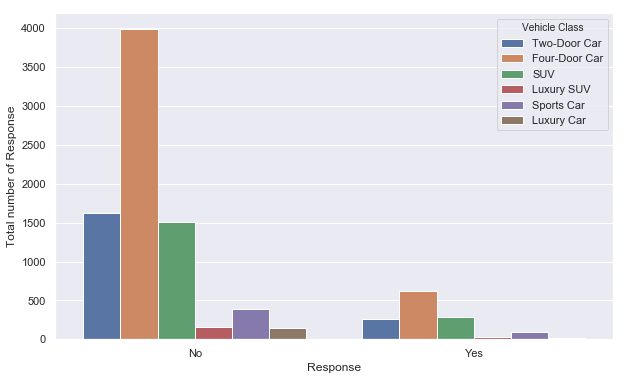

In [92]:
plt.figure(figsize=(10,6))
ax = sns.countplot('Response', hue = 'Vehicle Class', data = df)
plt.ylabel('Total number of Response')
plt.show()

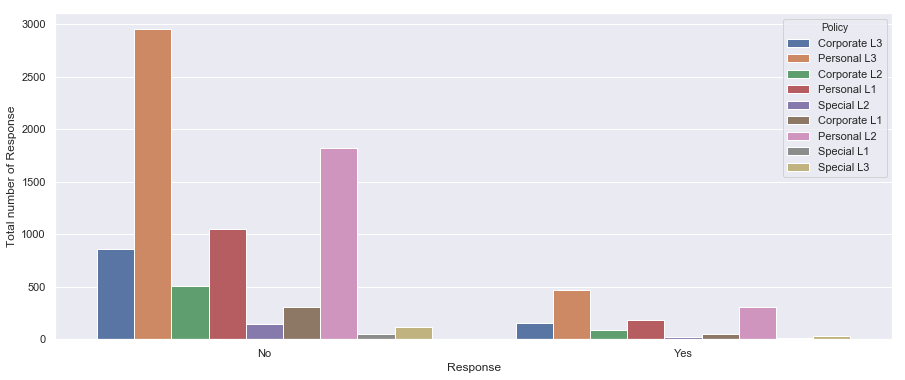

In [93]:
plt.figure(figsize=(15,6))
ax = sns.countplot('Response',hue = 'Policy', data = df)
plt.ylabel('Total number of Response')
plt.show()

## Processing

In [94]:
# Appending coded data
continous_var_df.reset_index(drop = True,inplace = True)
categorical_df.reset_index(drop = True,inplace = True)
new_data = pd.concat([continous_var_df,categorical_df],axis = 1)

In [95]:
new_data.head()

,Customer Lifetime Value,Income,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Total Claim Amount,Customer,State,...,EmploymentStatus,Gender,Location Code,Marital Status,Policy Type,Policy,Renew Offer Type,Sales Channel,Vehicle Class,Vehicle Size
0,2763.519279,56274,69,32,5,0,1,384.811147,600,4,...,1,0,1,1,0,2,0,0,5,1
1,6979.535903,0,94,13,42,0,8,1131.464935,5946,0,...,4,0,1,2,1,5,2,0,0,1
2,12887.431650,48767,108,18,38,0,2,566.472247,96,2,...,1,0,1,1,1,5,0,0,5,1
3,7645.861827,0,106,18,65,0,7,529.881344,8016,1,...,4,1,1,1,0,1,0,2,3,1
4,2813.692575,43836,73,12,44,0,1,138.130879,2488,4,...,1,1,0,2,1,3,0,0,0,1


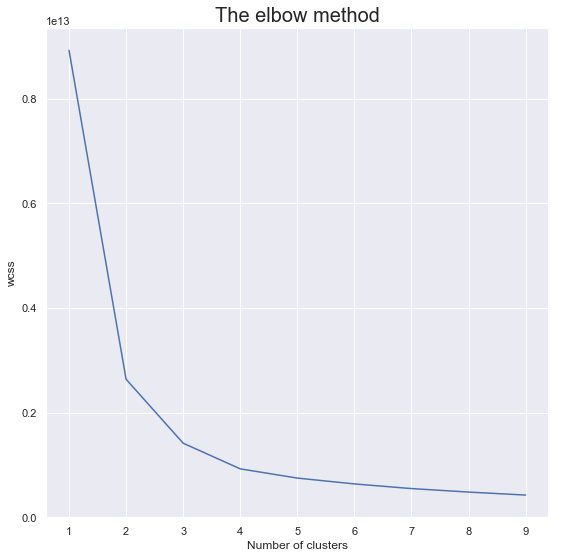

In [96]:
wcss = []
for i in range(1,10):
    km = KMeans(n_clusters = i,init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    km.fit(new_data)
    wcss.append(km.inertia_)
    
plt.plot(range(1,10),wcss)
plt.title('The elbow method', fontsize = 20)
plt.xlabel('Number of clusters')
plt.ylabel('wcss')
plt.show()


In [97]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [98]:
scaler.fit(new_data)
StandardScaler(copy=True,with_mean = True,with_std = True)
new_data_scaled = scaler.transform(new_data)

In [99]:
from sklearn.decomposition import PCA
model = PCA()
model.fit(new_data_scaled)


PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [100]:
features = range(model.n_components_)

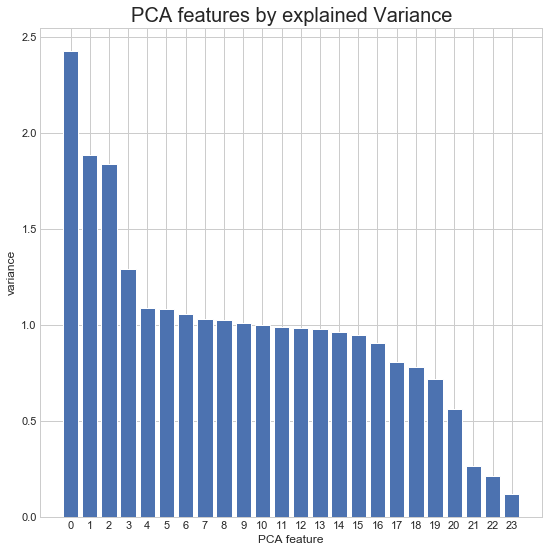

In [101]:
with plt.style.context('seaborn-whitegrid'):
    plt.bar(features,model.explained_variance_)
    plt.xticks(features)
    plt.ylabel('variance')
    plt.xlabel('PCA feature')
    plt.title('PCA features by explained Variance', fontsize = 20)
    plt.show()

In [102]:
pca = PCA(n_components = 2)
pca.fit(new_data_scaled)
transformed = pca.transform(new_data_scaled)

print(transformed.shape)

(9134, 2)


In [103]:
xs = transformed[:,0]
ys = transformed[:,1]


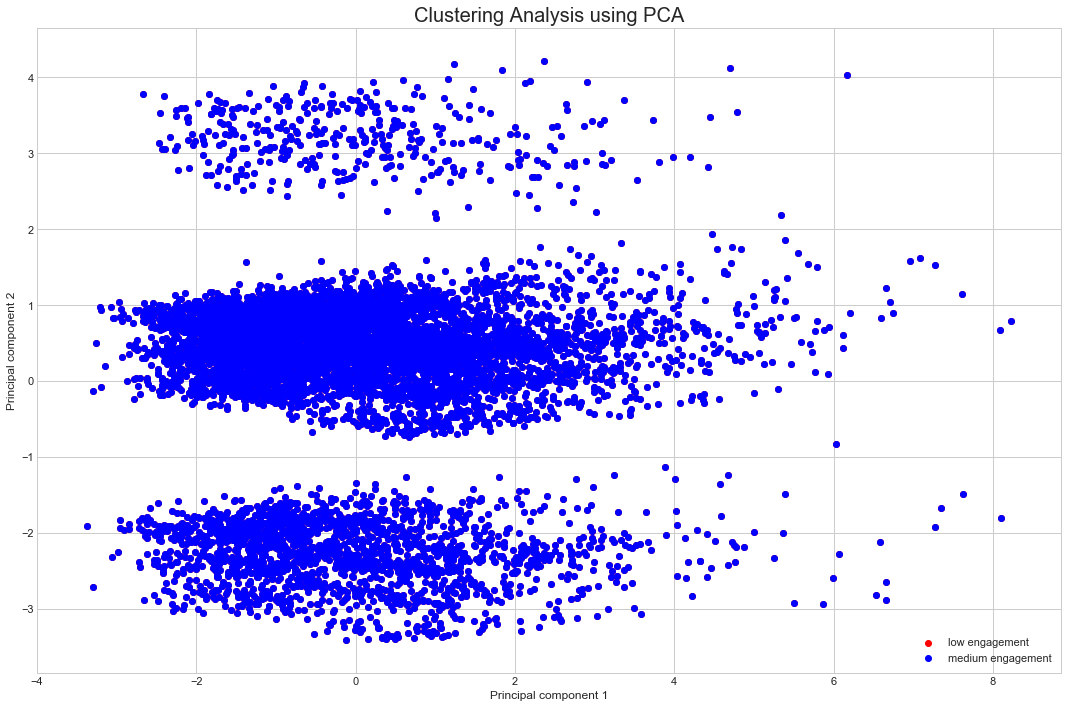

In [104]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize = (15,10))
    for lab, col in zip(('low engagement','medium engagement'),
                       ('red','blue')): 
        plt.scatter(xs,ys,label = lab,c= col,)
    plt.xlabel('Principal component 1')
    plt.ylabel('Principal component 2')
    plt.title('Clustering Analysis using PCA', fontsize = 20)
    plt.legend(loc = 'lower right')
    plt.tight_layout()
    plt.show()


## Findings
* Customer behaviours are observed to form two major classes. However, a third one appears to be lurking.
* Most customers are observed to have Medium engagement with the product
* Need for deeper understanding of features of the two main groups in order to increase engagement

